In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

# Load & Plot the Data

In [3]:
images = glob('drive/MyDrive/ML/train_cancer/*/*.jpg')
len(images)

3297

In [4]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[4]
df.head()


,filepath,label
0,drive/MyDrive/ML/train_cancer/benign/1662.jpg,benign
1,drive/MyDrive/ML/train_cancer/benign/1494.jpg,benign
2,drive/MyDrive/ML/train_cancer/benign/1700.jpg,benign
3,drive/MyDrive/ML/train_cancer/benign/1522.jpg,benign
4,drive/MyDrive/ML/train_cancer/benign/1690.jpg,benign


In [5]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()


,filepath,label,label_bin
0,drive/MyDrive/ML/train_cancer/benign/1662.jpg,benign,0
1,drive/MyDrive/ML/train_cancer/benign/1494.jpg,benign,0
2,drive/MyDrive/ML/train_cancer/benign/1700.jpg,benign,0
3,drive/MyDrive/ML/train_cancer/benign/1522.jpg,benign,0
4,drive/MyDrive/ML/train_cancer/benign/1690.jpg,benign,0


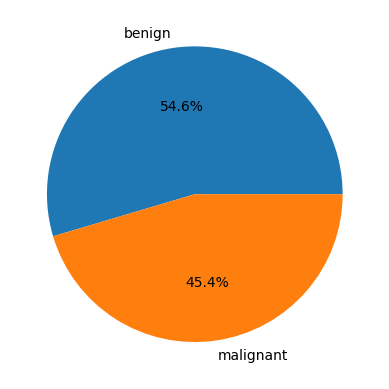

In [6]:
x = df['label'].value_counts()
plt.pie(x.values,
		labels=x.index,
		autopct='%1.1f%%')
plt.show()


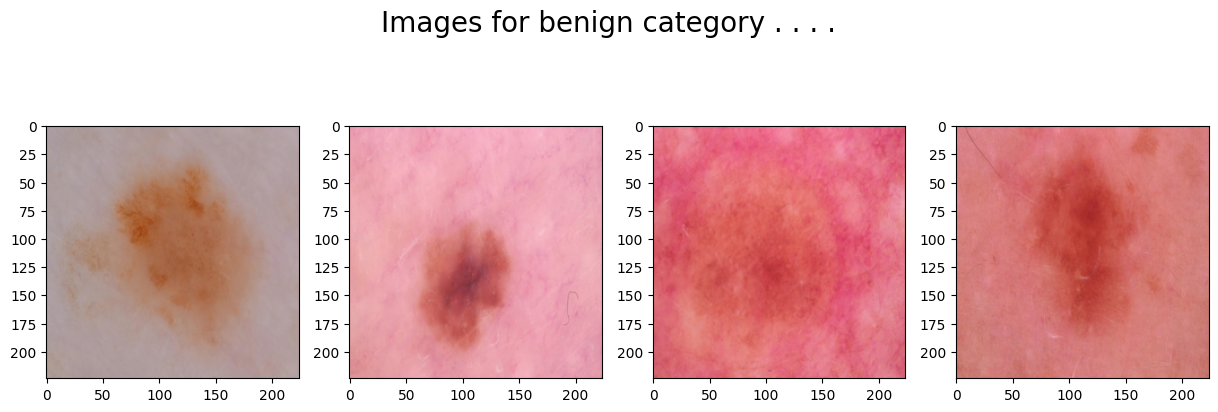

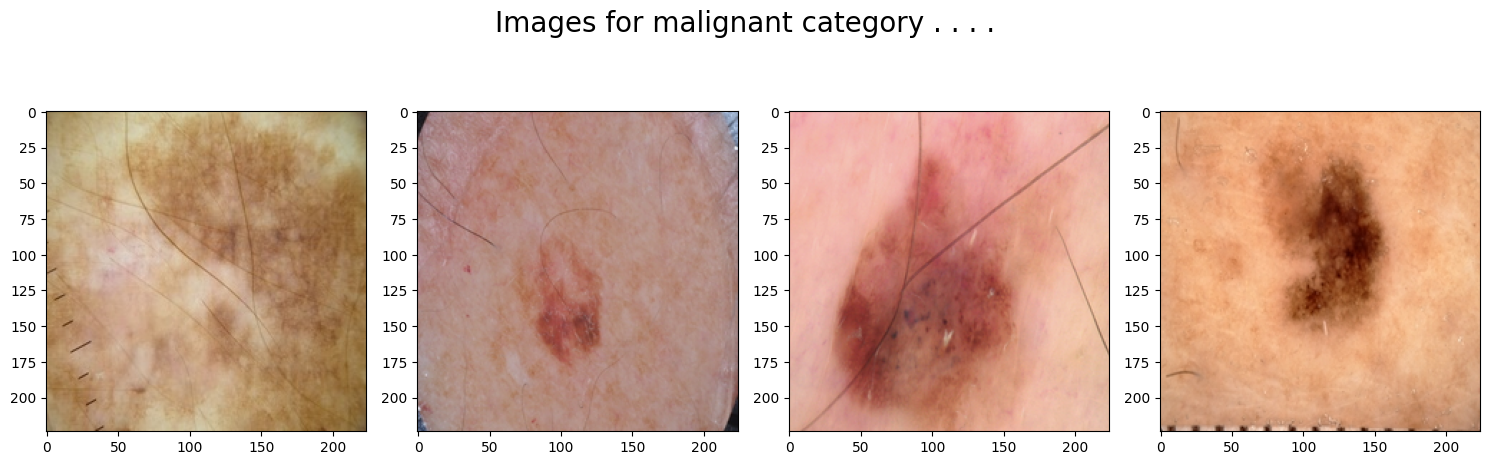

In [7]:
for cat in df['label'].unique():
	temp = df[df['label'] == cat]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()

# Prepare Dataset

In [19]:
features = df['filepath']
target = df['label_bin']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape

((2802,), (495,))

In [20]:
def decode_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


In [21]:
train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

# Model


### Pretrained Model - TF

In [22]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
	input_shape=(224, 224, 3),
	weights='imagenet',
	include_top=False
)

for layer in pre_trained_model.layers:
	layer.trainable = False

### Model - Fully connected (dense) neural network

In [23]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [24]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['AUC']
)


In [25]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=5,
					verbose=1)


Epoch 1/5
88/88 [==============================] - 524s 6s/step - loss: 0.5376 - auc: 0.8178 - val_loss: 3.7720 - val_auc: 0.5170
Epoch 2/5
88/88 [==============================] - 12s 134ms/step - loss: 0.4476 - auc: 0.8702 - val_loss: 0.5124 - val_auc: 0.8581
Epoch 3/5
88/88 [==============================] - 12s 131ms/step - loss: 0.4211 - auc: 0.8832 - val_loss: 0.4359 - val_auc: 0.8847
Epoch 4/5
88/88 [==============================] - 13s 146ms/step - loss: 0.3966 - auc: 0.8965 - val_loss: 0.4975 - val_auc: 0.8833
Epoch 5/5
88/88 [==============================] - 13s 146ms/step - loss: 0.3905 - auc: 0.9004 - val_loss: 0.7911 - val_auc: 0.8814


In [26]:
model.save('my_model.h5')

# Results

In [27]:
hist_df = pd.DataFrame(history.history)
hist_df.head()


,loss,auc,val_loss,val_auc
0,0.537647,0.817777,3.772007,0.516990
1,0.447615,0.870176,0.512390,0.858140
2,0.421128,0.883248,0.435892,0.884696
3,0.396640,0.896501,0.497472,0.883285
4,0.390462,0.900405,0.791095,0.881370


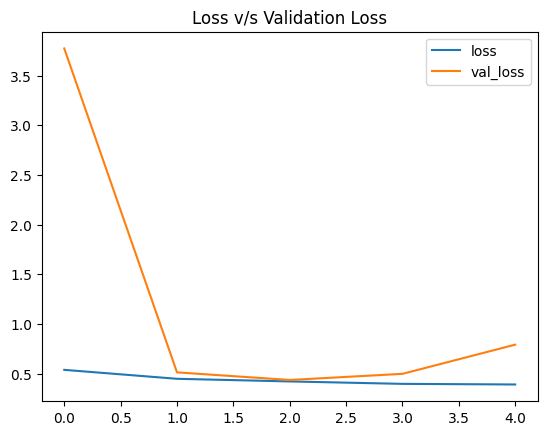

In [28]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()


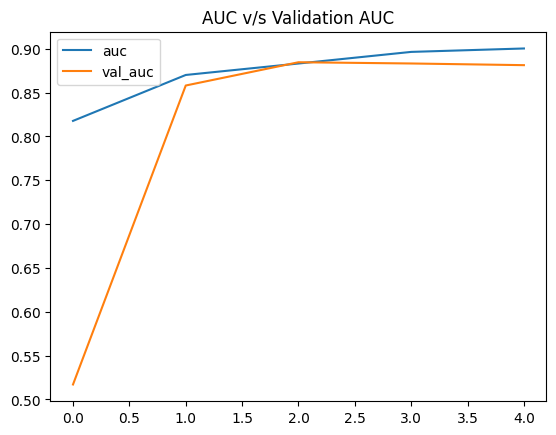

In [29]:
hist_df['auc'].plot()
hist_df['val_auc'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()


# Model Test with raw JPG

In [116]:

def decode_image_wo_label(filepath):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224])
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [159]:
imageVm = 'drive/MyDrive/ML/train_cancer/malignant/10.jpg'

In [160]:
decoded = decode_image_wo_label(imageVm)
decoded.shape
decoded = tf.expand_dims(decoded, axis=0)

In [161]:
predictions = model.predict(decoded)

1/1 [==============================] - 0s 27ms/step


In [162]:
print(predictions)

[[0.9901183]]
